In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.layers import *

In [ ]:
pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.5 MB/s eta 0:00:00


In [ ]:
# meat production vs. future percent change in stock price
# cold storage vs. measure of healthy/obesity
# stratify by location/race

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Summer Invitational Datathon Data 2024/"

In [ ]:
path = "/content/drive/MyDrive/Datathon Data/"

In [ ]:
# Stocks
STOCKS = pd.read_csv(path + "all_stock_and_etfs.csv")
STOCK_DES = pd.read_csv(path + "stock_descriptions.csv")

# Meat
WEIGHT = pd.read_csv(path + "Meat_Stats_Slaughter_Weights.csv")
PROD = pd.read_csv(path + "Meat_Stats_Meat_Production.csv")
COUNT = pd.read_csv(path + "Meat_Stats_Slaughter_Counts.csv")
STORAGE = pd.read_csv(path + "Meat_Stats_Cold_Storage.csv")

# Commodities
COMM = pd.read_csv(path + "all_commodities.csv")

# health/survey/economic data
NUTRITION = pd.read_csv(path + "Nutrition_Physical_Activity_and_Obesity_Data.csv")
ECON = pd.read_csv(path + "acs_5yr_est_selected_economic_characteristics_2010-2022.csv")
DOLLAR = pd.read_csv(path + "state_dollar_ag.csv")

<ipython-input-6-68e3af879dcd>:15: DtypeWarning: Columns (18,19,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  NUTRITION = pd.read_csv(path + "Nutrition_Physical_Activity_and_Obesity_Data.csv")


In [ ]:
def string_to_float(x):
  if type(x) == float:
    return x
  if x != x: # nan
    return None
  return float(x.replace(",", ""))

In [ ]:
def percent_to_float(string):
  if type(string) != str:
    return np.nan
  if not "%" in string:
    return np.nan
  return float(string.replace("%", ""))

In [ ]:
PROD["Production"] = PROD["Production"].apply(string_to_float)
COUNT["Count"] = COUNT["Count"].apply(string_to_float)
WEIGHT["Weight"] = WEIGHT["Weight"].apply(string_to_float)

STOCKS["Date-Time"] = pd.to_datetime(STOCKS["Date-Time"])
STORAGE["Date"] = pd.to_datetime(STORAGE["Date"])
WEIGHT["Date"] = pd.to_datetime(WEIGHT["Date"])
PROD["Date"] = pd.to_datetime(PROD["Date"])
COUNT["Date"] = pd.to_datetime(COUNT["Date"])
COMM["Date-Time"] = pd.to_datetime(COMM["Date-Time"])

ECON["Label (Grouping)"] = ECON["Label (Grouping)"].apply(lambda x: x.strip())
ECON["Percent"] = ECON["Percent"].apply(percent_to_float)

DOLLAR = DOLLAR[["State", "year", "count_452319"]]
DOLLAR.columns = ["State", "Year", "Count"]

<ipython-input-10-45d1eed071ca>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  STORAGE["Date"] = pd.to_datetime(STORAGE["Date"])
<ipython-input-10-45d1eed071ca>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  WEIGHT["Date"] = pd.to_datetime(WEIGHT["Date"])
<ipython-input-10-45d1eed071ca>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PROD["Date"] = pd.to_datetime(PROD["Date"])
<ipython-input-10-45d1eed071ca>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, p

# Organizing Meat Data

In [ ]:
global_animals = ["Beef", "Calves", "Pork", "Lamb", "Broiler", "Other Chicken", "Turkey"]

prod_animals = ["Beef", "Veal", "Pork", "Lamb and Mutton", "Broilers", "Other Chicken", "Turkey"]
weight_animals = ["Cattle", "Calves", "Hogs", "Sheep and Lambs", "Broilers", "Other Chickens", "Turkeys"]
storage_animals = ["Beef", "Veal", "Pork", "Lamb and Mutton", "Broiler", "Other Chicken", "Turkey"]
counts_animals = [["Cattle", "Steers", "Heifers", "Beef Cows", "Bulls and Stags"], ["Calves"],
                  ["Hogs", "Barrows and Gilts", "Boars and Stags"], ["Sheep and Lambs", "Lambs and Yearlings", "Mature Sheep"],
                  ["Broilers"], ["Other chickens"], ["Turkeys"]]

meat_animals = [prod_animals, weight_animals, storage_animals, counts_animals]
for i in meat_animals:
  assert len(i) == len(global_animals)

In [ ]:
PROD_dict = {}
for i in range(len(prod_animals)):
  print("Processing {} Data".format(prod_animals[i]))
  df_animal = PROD[(PROD["Animal"] == prod_animals[i]) & (PROD["Commercial or Federally Inspected"] == "Federally Inspected")][["Date", "Production"]]
  df_animal.set_index("Date", inplace=True)
  df_animal.sort_index(inplace=True)
  print("{} NaN values".format(df_animal["Production"].isnull().sum()))
  PROD_dict[global_animals[i]] = df_animal

Processing Beef Data
236 NaN values
Processing Veal Data
236 NaN values
Processing Pork Data
236 NaN values
Processing Lamb and Mutton Data
236 NaN values
Processing Broilers Data
468 NaN values
Processing Other Chicken Data
959 NaN values
Processing Turkey Data
469 NaN values


In [ ]:
# Weight has no NaNs, we are dividing federally inspected dressed by federally inspected live and extracting these values

In [ ]:
WEIGHT_dict = {}
for i in range(len(weight_animals)):
  print("Processing {} Data".format(weight_animals[i]))
  df_dressed = WEIGHT[(WEIGHT["Animal"] == weight_animals[i]) &
                     (WEIGHT["Commercial_Or_Federally_Inspected"] == "Federally Inspected") &
                     (WEIGHT["Live_Or_Dressed"] == "Dressed")][["Date", "Weight"]]
  df_live = WEIGHT[(WEIGHT["Animal"] == weight_animals[i]) &
                     (WEIGHT["Commercial_Or_Federally_Inspected"] == "Federally Inspected") &
                     (WEIGHT["Live_Or_Dressed"] == "Live")][["Date", "Weight"]]
  if df_dressed["Weight"].shape[0] == 0:
    WEIGHT_dict[global_animals[i]] = None
    print("No data for {}".format(global_animals[i]))
    continue
  df_animal = pd.DataFrame({"Date": df_live["Date"], "WeightRatio": df_dressed["Weight"].values / df_live["Weight"].values})
  df_animal.set_index("Date", inplace=True)
  df_animal.sort_index(inplace=True)
  print("{} NaN values".format(df_animal["WeightRatio"].isnull().sum()))
  WEIGHT_dict[global_animals[i]] = df_animal

Processing Cattle Data
0 NaN values
Processing Calves Data
0 NaN values
Processing Hogs Data
0 NaN values
Processing Sheep and Lambs Data
0 NaN values
Processing Broilers Data
No data for Broiler
Processing Other Chickens Data
No data for Other Chicken
Processing Turkeys Data
No data for Turkey


In [ ]:
STORAGE_dict = {}
for i in range(len(storage_animals)):
  print("Processing {} Data".format(storage_animals[i]))
  df_animal = STORAGE[STORAGE["Animal"] == storage_animals[i]][["Date", "Weight"]]
  df_animal.set_index("Date", inplace=True)
  df_animal.sort_index(inplace=True)
  print("{} NaN values".format(df_animal["Weight"].isnull().sum()))
  STORAGE_dict[global_animals[i]] = df_animal

Processing Beef Data
0 NaN values
Processing Veal Data
0 NaN values
Processing Pork Data
0 NaN values
Processing Lamb and Mutton Data
0 NaN values
Processing Broiler Data
245 NaN values
Processing Other Chicken Data
0 NaN values
Processing Turkey Data
0 NaN values


In [ ]:
COUNT_dict = {}
for i in range(len(counts_animals)):
  print("Processing {} Data".format(global_animals[i]))
  df_temp = pd.DataFrame({"Date": COUNT[COUNT["Animal"] == counts_animals[i][0]]["Date"].iloc[:493], "Count": np.zeros((493))})
  for j in range(len(counts_animals[i])):
    print("\tProcessing {} Data".format(counts_animals[i][j]))
    df_animal = COUNT[(COUNT["Animal"] == counts_animals[i][j]) &
                      (COUNT["Commercial_Or_Federally_Inspected"] == "Federally Inspected")]["Count"]
    df_temp["Count"] += df_animal.values
    print("\t{} NaN values".format(df_temp["Count"].isnull().sum()))
  df_temp.set_index("Date", inplace=True)
  df_temp.sort_index(inplace=True)
  COUNT_dict[global_animals[i]] = df_temp

Processing Beef Data
	Processing Cattle Data
	0 NaN values
	Processing Steers Data
	0 NaN values
	Processing Heifers Data
	0 NaN values
	Processing Beef Cows Data
	0 NaN values
	Processing Bulls and Stags Data
	0 NaN values
Processing Calves Data
	Processing Calves Data
	0 NaN values
Processing Pork Data
	Processing Hogs Data
	0 NaN values
	Processing Barrows and Gilts Data
	0 NaN values
	Processing Boars and Stags Data
	0 NaN values
Processing Lamb Data
	Processing Sheep and Lambs Data
	0 NaN values
	Processing Lambs and Yearlings Data
	0 NaN values
	Processing Mature Sheep Data
	0 NaN values
Processing Broiler Data
	Processing Broilers Data
	0 NaN values
Processing Other Chicken Data
	Processing Other chickens Data
	217 NaN values
Processing Turkey Data
	Processing Turkeys Data
	0 NaN values


# Organizing Stock Data

In [ ]:
trade_service_tickers = list(STOCK_DES[STOCK_DES["Sector"] == "TRADE & SERVICES"]["Symbol"])
tech_tickers = list(STOCK_DES[STOCK_DES["Sector"] == "TECHNOLOGY"]["Symbol"])
manufac_tickers = list(STOCK_DES[STOCK_DES["Sector"] == "MANUFACTURING"]["Symbol"])
etf_tickers = list(STOCK_DES[STOCK_DES["Sector"] == "MULTIPLE"]["Symbol"])

In [ ]:
def stock_price_history(ticker):
  # Use Yahoo Finance instead of provided data because of unaccounted stock splits
  stock_data = yf.Ticker(ticker).history(period="max")
  if stock_data.shape[0] == 0:
    return None
  stock_data.index = stock_data.index.strftime('%Y-%m-%d')
  stock_data.index = pd.to_datetime(stock_data.index)
  return stock_data[["Open", "High", "Low", "Close", "Volume"]]

# def stock_price_history(ticker):
#   # Columns: [Open, High, Low, Close, Volume]
#   history = STOCKS[STOCKS["Ticker_Symbol"] == ticker].iloc[::-1]
#   history.set_index("Date-Time", inplace=True)
#   return history.iloc[:,:-1]

In [ ]:
all_tickers = STOCKS["Ticker_Symbol"].unique()
all_stock_data = {ticker: stock_price_history(ticker) for ticker in all_tickers}
all_stock_data = {key: value for key, value in all_stock_data.items() if value is not None}

ERROR:yfinance:$CNHI: possibly delisted; No timezone found


In [ ]:
def run_granger_causality(x, y, maxlag=15, reverse=False):
  assert x.shape[0] == y.shape[0]
  x = x.diff().dropna()
  y = y.diff().dropna()

  # Dicker-Fuller test to check for stationarity
  # print(adfuller(x)[1])
  # print(adfuller(y)[1])
  if reverse:
    df = pd.concat([y.reset_index(drop=True), x.reset_index(drop=True)], axis=1)
  else:
    df = pd.concat([x.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
  results_dict = grangercausalitytests(df, maxlag=maxlag)
  avg_pvals = {lag: np.mean([value[1] for key, value in results_dict[lag][0].items()]) for lag in range(1, maxlag + 1)}
  # returns a dictionary with lag times as keys and average p values from the 4 significance tests as values
  return avg_pvals

In [ ]:
def join_by_month(df1, df2):
  # df1.index = df1.index.strftime("%Y-%m")
  # df1.index = pd.to_datetime(df1.index)
  # df2.index = df2.index.strftime("%Y-%m")
  # df2.index = pd.to_datetime(df2.index)
  df1 = pd.DataFrame(df1)
  df2 = pd.DataFrame(df2)
  df1["Year"] = df1.index.year
  df1["Month"] = df1.index.month
  df2["Year"] = df2.index.year
  df2["Month"] = df2.index.month
  merged = pd.merge(df1, df2, on=["Year", "Month"])
  merged["Date"] = pd.to_datetime(merged[["Year", "Month"]].assign(day=1))
  merged.set_index("Date", inplace=True)
  merged.drop(["Year", "Month"], axis=1, inplace=True)
  return merged

In [ ]:
# Run with PROD_dict and WEIGHT_dict
# Run with Beef and Broiler
best_lag_times = {} # meat production causes stock movement
best_lag_times_rev = {} # stock movement causes meat production
for ticker, data in all_stock_data.items():
  print(ticker)
  monthly_average = data.resample("M").mean()
  granger_input = join_by_month(monthly_average["Close"], PROD_dict["Beef"][PROD_dict["Beef"].index > "1983"])
  results = run_granger_causality(granger_input.iloc[:,0], granger_input.iloc[:,1])
  # print("Best Lag Time: {}, p-value: {}".format(min(results, key=results.get), min(results.values())))
  results_rev = run_granger_causality(granger_input.iloc[:,0], granger_input.iloc[:,1], reverse=True)
  best_lag_times[ticker] = (min(results, key=results.get), min(results.values()))
  best_lag_times_rev[ticker] = (min(results_rev, key=results_rev.get), min(results_rev.values()))

Streaming output truncated to the last 5000 lines.

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6155  , p=0.8003  , df_denom=280, df_num=10
ssr based chi2 test:   chi2=6.6169  , p=0.7610  , df=10
likelihood ratio test: chi2=6.5452  , p=0.7676  , df=10
parameter F test:         F=0.6155  , p=0.8003  , df_denom=280, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.5733  , p=0.8500  , df_denom=277, df_num=11
ssr based chi2 test:   chi2=6.8302  , p=0.8127  , df=11
likelihood ratio test: chi2=6.7536  , p=0.8187  , df=11
parameter F test:         F=0.5733  , p=0.8500  , df_denom=277, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.9575  , p=0.4901  , df_denom=274, df_num=12
ssr based chi2 test:   chi2=12.5377 , p=0.4035  , df=12
likelihood ratio test: chi2=12.2820 , p=0.4233  , df=12
parameter F test:         F=0.9575  , p=0.4901  , df_denom=274, df_num=12

Granger Causality
number of

In [ ]:
sorted(best_lag_times.items(), key=lambda kv: kv[1][1])

[('PEP', (11, 0.0009375828166473294)),
 ('SBUX', (3, 0.0016574426547989946)),
 ('HRL', (5, 0.0037874863457184197)),
 ('MCD', (5, 0.010318616289329337)),
 ('YUM', (4, 0.01830592370092262)),
 ('HSY', (11, 0.02134415703893286)),
 ('SPY', (1, 0.0277176650864122)),
 ('SAP', (15, 0.0353613214538779)),
 ('VOO', (1, 0.0413601008882869)),
 ('DPZ', (1, 0.04140759536034867)),
 ('ONEQ', (1, 0.04363007855817819)),
 ('WEN', (12, 0.04467684871331253)),
 ('TSN', (12, 0.0456211427377787)),
 ('TSCO', (15, 0.04963149176001802)),
 ('CAG', (1, 0.05728280935062642)),
 ('QSR', (14, 0.0608118739708731)),
 ('DE', (14, 0.06709793743897367)),
 ('CMG', (14, 0.07968886703756806)),
 ('GIS', (1, 0.14066649134686876)),
 ('DIA', (1, 0.15058921715308843)),
 ('AGCO', (11, 0.15854898620754596)),
 ('PPC', (3, 0.17600990311614673)),
 ('DRI', (14, 0.18888182962103173)),
 ('VMI', (2, 0.19030125307048357)),
 ('ALG', (15, 0.2170682944581458)),
 ('CAT', (1, 0.5376023634377062)),
 ('COKE', (1, 0.566595603915025)),
 ('ADM', (8, 0

In [ ]:
sorted(best_lag_times_rev.items(), key=lambda kv: kv[1][1])

[('MCD', (14, 1.7262538998589747e-07)),
 ('TSN', (9, 8.548047919808311e-07)),
 ('DRI', (13, 1.414286868509782e-06)),
 ('HSY', (10, 2.4092729871891033e-05)),
 ('SPY', (14, 2.5891309819806457e-05)),
 ('CAG', (15, 4.2817527424881276e-05)),
 ('ALG', (14, 5.4546237653519425e-05)),
 ('DIA', (14, 9.463744607733788e-05)),
 ('SBUX', (11, 0.0008664366662687044)),
 ('ONEQ', (14, 0.00107783217339181)),
 ('QSR', (2, 0.001528998217401567)),
 ('WEN', (14, 0.0016233740642046946)),
 ('YUM', (15, 0.0018692469533227421)),
 ('SAP', (14, 0.0020867633902664703)),
 ('DPZ', (14, 0.0038805984404722115)),
 ('PPC', (2, 0.008581232973769726)),
 ('PEP', (15, 0.00981603100952959)),
 ('COKE', (13, 0.010105262625740302)),
 ('ADM', (14, 0.01189819517936774)),
 ('HRL', (12, 0.01230550389407667)),
 ('AGCO', (14, 0.012971473740578188)),
 ('VOO', (2, 0.01620341635456706)),
 ('CMG', (2, 0.024663142439540455)),
 ('DE', (14, 0.03498400851981023)),
 ('TSCO', (10, 0.045628235918002386)),
 ('VMI', (14, 0.05230171245954317)),
 (

In [ ]:
# KDP, MNST are in metadata but there's no data for them in the actual stock data

# Econ Stuff

In [ ]:
headers = ECON[ECON["Category"] == "Header"]["Label (Grouping)"].unique()
headers

array(['EMPLOYMENT STATUS', 'COMMUTING TO WORK', 'OCCUPATION', 'INDUSTRY',
       'CLASS OF WORKER',
       'INCOME AND BENEFITS (IN 2010 INFLATION-ADJUSTED DOLLARS)',
       'HEALTH INSURANCE COVERAGE',
       'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL',
       'INCOME AND BENEFITS (IN 2011 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2013 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2012 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2016 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2014 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)',
       'INCOME AND B

In [ ]:
states = list(ECON["State"].unique())
assert len(states) == 52
state_abbreviations = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA',
    'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
    'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'
]

In [ ]:
def find_correlations(df):
  beef_unemployment_dict = {}
  for i in range(len(states)):
    # fig, ax1 = plt.subplots()

    # color = 'tab:red'
    # ax1.set_xlabel('Year')
    # ax1.set_ylabel('unemployment rate', color=color)
    # ax1.plot(np.arange(2010,2023), poverty_dict[social_groups[0]][poverty_dict[social_groups[0]]["State"] == states[i]]["Percent"], color=color)
    # ax1.tick_params(axis='y', labelcolor=color)

    # ax2 = ax1.twinx()

    # color = 'tab:blue'
    # ax2.set_ylabel('beef storage (million lb)', color=color)  # we already handled the x-label with ax1
    # ax2.plot(np.arange(2010,2023), STORAGE_dict["Beef"][(STORAGE_dict["Beef"].index >= "2010") & (STORAGE_dict["Beef"].index <= "2022")].resample("Y").mean(), color=color)
    # ax2.tick_params(axis='y', labelcolor=color)

    # fig.tight_layout()
    # ax1.set_title(states[i])
    # plt.show()

    x = pd.DataFrame(df[df["State"] == states[i]]["Percent"].pct_change().dropna())
    y = PROD_dict["Beef"][(PROD_dict["Beef"].index >= "2010") & (PROD_dict["Beef"].index <= "2022")].resample("Y").mean().pct_change().dropna()
    # plt.scatter(x, y)
    # plt.show()
    correlation = x.reset_index(drop=True)["Percent"].corr(y.reset_index(drop=True)["Production"])
    print("{}: {}".format(states[i], correlation))
    beef_unemployment_dict[states[i]] = correlation
  return beef_unemployment_dict

In [ ]:
category = "PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL"
social_groups = ["Married couple families", "Families with female householder, no husband present"]
poverty_dict = {social_groups[i]: ECON[(ECON["Category"] == category) & (ECON["Label (Grouping)"] == social_groups[i])][["State", "Percent", "Year"]].set_index("Year").sort_values(by=["Year", "State"])
                for i in range(len(social_groups))}
# for key, value in poverty_dict.items():
#   poverty_dict[key]["Percent"] = poverty_dict[key]["Percent"].apply(percent_to_float)
# poverty_dict = {key: value["Percent"].apply(percent_to_float) for key, value in poverty_dict.items()}

In [ ]:
ln = px.line(poverty_dict[social_groups[1]], y = "Percent", color = "State")
ln.show()

In [ ]:
np.mean(list(beef_unemploy_singlemother_dict.values())) - np.mean(list(beef_unemploy_families_dict.values()))

-0.1701873468347218

In [111]:
obesity_dict = {}
for q in obesity_questions:
  obesity_dict[q] = {}
  for r in races:
    lst = []
    for s in state_abbreviations:
      temp = obesity_data[q][r][obesity_data[q][r]["LocationAbbr"] == s]["Data_Value"].dropna()
      if temp.shape[0] == 0:
        obesity_dict[q][r] = np.nan
        continue
      lst.append(temp.iloc[-1] - temp.iloc[0])
    obesity_dict[q][r] = np.mean(lst)

In [ ]:
beef_unemploy_families_dict = find_correlations(poverty_dict[social_groups[0]])
beef_unemploy_singlemother_dict = find_correlations(poverty_dict[social_groups[1]])

Alabama: -0.5182979916326134
Alaska: -0.03620503078807919
Arizona: -0.4379143185658837
Arkansas: -0.5059533757642427
California: -0.5318553156401721
Colorado: -0.42879727033420995
Connecticut: -0.4990352556839243
Delaware: -0.12303112000410114
District of Columbia: -0.39516178501604365
Florida: -0.40533291969962143
Georgia: -0.4450213609829073
Hawaii: -0.5558247833684066
Idaho: -0.40001872636047453
Illinois: -0.47646218193510154
Indiana: -0.36326600260173353
Iowa: -0.3577214434400782
Kansas: -0.4185395223327495
Kentucky: -0.3363261075634523
Louisiana: -0.5467438174668091
Maine: -0.5748064458216184
Maryland: -0.5788490606051074
Massachusetts: -0.4344914253772119
Michigan: -0.4852731930664918
Minnesota: -0.37687988326009825
Mississippi: -0.4125568815132005
Missouri: -0.5060995473025665
Montana: 0.15730819601198703
Nebraska: -0.4715036260734868
Nevada: -0.44420232463081966
New Hampshire: -0.3858011637115225
New Jersey: -0.3581086299900196
New Mexico: -0.3291030517433296
New York: -0.59354

In [ ]:
def draw_map(corr_dict, save=False, title=None):
  df = pd.DataFrame(corr_dict.items(), columns=["State", "Corr"])
  fig = px.choropleth(df,
                      locations=state_abbreviations,
                      locationmode='USA-states',
                      color='Corr', color_continuous_scale="Spectral",
                      hover_name='State',
                      scope='usa',
                      labels={'Corr': 'Corr.'})
                      # title='Choropleth Map of All States Plus DC')

  # fig.add_scattergeo(
  #     locations=state_abbreviations,
  #     locationmode="USA-states",
  #     text=round(df["Corr"], 1),
  #     mode='text',
  # )
  fig.update_layout(coloraxis_colorbar_x=-0.05)
  # fig.update_layout(
  #     font=dict(
  #         size=8,
  #         color="Black"
  #     )
  # )
  if save:
    fig.write_image(title, scale=4)
  fig.show()

In [ ]:
draw_map(beef_unemploy_singlemother_dict, save=True, title="beef_unemploy_singlemother.png")

In [ ]:
# There is moderate negative correlation between beef production and counts and unemployment (across most states) in families
# This negative correlation is more pronounced in single family households

In [ ]:
health_data = ECON[(ECON["Category"] == "HEALTH INSURANCE COVERAGE") & (ECON["Label (Grouping)"] == "With health insurance coverage")][["State", "Estimate", "Percent", "Year"]]
health_data = health_data.groupby(["Year", "State"])["Percent"].mean().reset_index().set_index("Year")

In [ ]:
px.line(health_data, y="Percent", color="State")

In [ ]:
social_groups = ["$100,000 to $149,999", "$150,000 to $199,999", "$200,000 or more"]
income = ECON[(ECON["Category"].isin([i for i in headers if i.startswith("INCOME")])) & (ECON["Label (Grouping)"].isin(social_groups))][["State", "Percent", "Year"]].set_index("Year").sort_values(by=["Year", "State"])
income = (income.groupby(["Year", "State"]).sum() / 2).reset_index().set_index("Year")
px.line(income, y="Percent", color="State")

In [71]:
income_pct_change = []
for s in states:
   income_pct_change.append((income[income["State"] == s]["Percent"].iloc[-1] - income[income["State"] == s]["Percent"].iloc[0]) / income[income["State"] == s]["Percent"].iloc[0])
print(np.mean(income_pct_change))

0.8809963672211243


In [82]:
health_pct_change = []
for s in states:
   temp = health_data[health_data["State"] == s]["Percent"].dropna()
   health_pct_change.append(temp.iloc[-1] - temp.iloc[0])
print(np.nanmean(health_pct_change))

9.039903846153845


In [85]:
obesity_data[obesity_questions[0]]

NameError: name 'obesity_data' is not defined

In [ ]:
# for i in range(len(states)):
#   x = income[income["State"] == states[i]]["Percent"].pct_change().dropna()
#   y = health_data[health_data["State"] == states[i]]["Percent"].pct_change().dropna()
#   merged = pd.merge(x, y, on="Year")
#   # plt.scatter(merged["Percent_x"], merged["Percent_y"])
#   # plt.show()
#   print(merged["Percent_x"].corr(merged["Percent_y"]))

-0.3126468176294524
-0.23945317879058176
-0.1329660873250336
-0.4040669847195332
-0.06797006937758064
-0.3153621887688355
-0.34013591535300747
-0.5296612524853019
-0.10561544629050014
-0.1451904101462885
-0.06323525291298682
-0.08334984175103603
0.19114520937757648
-0.250962006829162
-0.0331604811466507
-0.5206366121426882
-0.41704951476444435
-0.2713064620470648
-0.2207530660582901
0.32784762699661835
-0.5918544707421266
-0.2940914338209806
-0.09038680884402465
-0.40766019566649875
-0.3712782873293019
-0.11227087800695695
-0.05469773560574534
0.1764225691669199
-0.21818652590725846
0.05158007304035141
0.010365360422016225
-0.4934192932596178
-0.37499416020760323
-0.20958923035237767
-0.09929126908708816
-0.35561021585226926
0.12449095026357056
-0.20067952051875118
-0.25595817813176436
-0.18649798034682175
-0.20867545575194626
0.28931766620345145
-0.2877085806977509
-0.43026728144646026
-0.06399366465740162
-0.7975348004129018
0.13733957878374545
-0.08981762571966823
-0.561578113809576

In [ ]:
# As income increases (namely the proportion of state population earning >$100K), meat production and counts increases as well
# but not storage or weight (does not supporting the hoarding hypothesis)
# This strong positive correlation is only observed for beef, not chicken (broiler) or pork, as beef is a luxury good whose demand increases with income
# On the other hand, it is reasonable that the demand of normal goods like chicken will remain fairly constant wrt income, supported by lower or non-existent correlations

In [ ]:
all_animals_income = {}
for animal in global_animals:
  beef_income_dict = {}
  for i in range(len(states)):
    x = income[income["State"] == states[i]]["Percent"].pct_change().dropna()
    y = COUNT_dict[animal].resample("Y").mean().pct_change().dropna()
    y = y[(y.index >= "2010") & (y.index <= "2022")]
    # plt.scatter(x, y)
    # plt.show()
    correlation = x.reset_index(drop=True).corr(y.reset_index(drop=True)["Count"])
    print("{}: {}".format(states[i], correlation))
    beef_income_dict[states[i]] = correlation
  all_animals_income[animal] = np.mean(list(beef_income_dict.values()))

Alabama: 0.5569968325262407
Alaska: 0.22258921829681333
Arizona: 0.4976311005534359
Arkansas: 0.5842707020741567
California: 0.5963445867486126
Colorado: 0.5865388241571496
Connecticut: 0.5345992766385236
Delaware: 0.638571706046797
District of Columbia: 0.8316756397868639
Florida: 0.5021443587882457
Georgia: 0.5676894863052057
Hawaii: 0.48379450750225667
Idaho: 0.47518845688563904
Illinois: 0.5595990525779645
Indiana: 0.5464795690408855
Iowa: 0.5277560819433789
Kansas: 0.4750633238961863
Kentucky: 0.5197464589999238
Louisiana: 0.4118357200542178
Maine: 0.5656477794190762
Maryland: 0.6424580598341498
Massachusetts: 0.6511688499085011
Michigan: 0.45888222703135817
Minnesota: 0.559306162704025
Mississippi: 0.5392966352108653
Missouri: 0.5769412165993059
Montana: 0.49264753636573516
Nebraska: 0.38671435437344104
Nevada: 0.5237117461886355
New Hampshire: 0.5166302336103402
New Jersey: 0.5797394074372448
New Mexico: 0.4314654404610559
New York: 0.609914442882129
North Carolina: 0.5143149619

In [ ]:
all_animals_income

{'Beef': 0.5150438542083992,
 'Calves': 0.0027157420929315953,
 'Pork': -0.01463710898504366,
 'Lamb': 0.05605778545933095,
 'Broiler': 0.157232059412249,
 'Other Chicken': -0.026841131251987956,
 'Turkey': -0.16768983265767773}

In [ ]:
draw_map(beef_income_dict, save=True, title="turkey_income.png")

# Health

In [ ]:
NUTRITION.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource',
       'Class', 'Topic', 'Question', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
       'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit',
       'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Grade',
       'Income', 'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID',
       'QuestionID', 'DataValueTypeID', 'LocationID',
       'StratificationCategory1', 'Stratification1',
       'StratificationCategoryId1', 'StratificationID1'],
      dtype='object')

In [86]:
obesity_questions = NUTRITION[NUTRITION["Class"] == "Obesity / Weight Status"]["Question"].unique()

In [87]:
races = ["American Indian/Alaska Native", "Hispanic", "Non-Hispanic White", "Hawaiian/Pacific Islander", "Asian", "Non-Hispanic Black"]

In [88]:
obesity_data = {}
for q in obesity_questions:
  for r in races:
    temp = NUTRITION[(NUTRITION["Question"] == q) & (NUTRITION["Stratification1"] == r)][["YearStart", "LocationAbbr", "Data_Value"]]
    temp = temp.sort_values(["YearStart", "LocationAbbr"])
    temp.set_index("YearStart", inplace=True)
    if not q in obesity_data.keys():
      obesity_data[q] = {}
    obesity_data[q][r] = temp

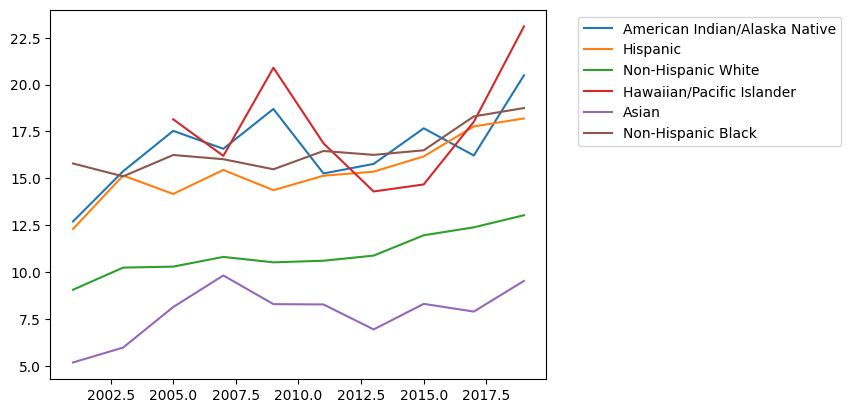

In [89]:
for r in races:
  plt.plot(obesity_data[obesity_questions[0]][r].groupby("YearStart")["Data_Value"].mean(), label=r)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
NUTRITION.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource',
       'Class', 'Topic', 'Question', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
       'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit',
       'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Grade',
       'Income', 'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID',
       'QuestionID', 'DataValueTypeID', 'LocationID',
       'StratificationCategory1', 'Stratification1',
       'StratificationCategoryId1', 'StratificationID1'],
      dtype='object')

In [ ]:
NUTRITION["Class"].unique()

array(['Physical Activity', 'Obesity / Weight Status', 'Sugar Drinks',
       'Fruits and Vegetables', 'Television Viewing'], dtype=object)

In [ ]:
NUTRITION["Question"].unique()

array(['Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily',
       'Percent of students in grades 9-12 who have obesity',
       'Percent of students in grades 9-12 who participate in daily physical education',
       'Percent of students in grades 9-12 who have an overweight classification',
       'Percent of students in grades 9-12 who drank regular soda/pop at least one time per day',
       'Percent of students in grades 9-12 who consume vegetables less than 1 time daily',
       'Percent of students in grades 9-12 who consume fruit less than 1 time daily',
       'Percent of students in grades 9-12 watching 3 or more hours of television each school day',
       'Percent of adults who engage in no leisure-time physical activity',
       'Percent of adults aged 18 years and older who have obesity',
       'Percent of adults aged 18 years and older who have an overweight classification',
       'Percent of adu

In [ ]:
px.line(obesity_data["Percent of adults aged 18 years and older who have obesity"]["Asian"], color="LocationAbbr", y="Data_Value")

In [118]:
diet_questions = ["Percent of adults who engage in muscle-strengthening activities on 2 or more days a week",
                  "Percent of adults who report consuming fruit less than one time daily",
                  "Percent of adults who report consuming vegetables less than one time daily"]

In [119]:
diet_data = {}
social_groups = ["18 - 24", "25 - 34", "35 - 44", "45 - 54", "55 - 64", "65 or older"]
for q in diet_questions:
  for s in social_groups:
    temp = NUTRITION[(NUTRITION["Question"] == q) & (NUTRITION["Stratification1"] == s)][["YearStart", "LocationAbbr", "Data_Value"]].sort_values(["YearStart", "LocationAbbr"]).set_index("YearStart")
    if not q in diet_data.keys():
      diet_data[q] = {}
    diet_data[q][s] = temp

In [120]:
healthcare_diet_dict = {}
for q in diet_questions:
  healthcare_diet_dict[q] = {}
  for i in range(len(states)):
    healthcare_diet_dict[q][states[i]] = {}
    for s in social_groups:
      x = health_data[health_data["State"] == states[i]]["Percent"].pct_change().dropna().iloc[:7]
      temp = diet_data[q][s][diet_data[q][s]["LocationAbbr"] == state_abbreviations[i]]["Data_Value"]
      full_index = pd.Index(range(temp.index.min(), temp.index.max() + 1), name='year')
      temp = temp.reindex(full_index)
      temp = temp.interpolate()
      y = temp.pct_change().dropna().iloc[1:]
      # print(x.shape)
      # print(y.shape)
      if y.shape[0] >= 7:
        # plt.scatter(x, y)
        # plt.show()
        correlation = x.corr(y)
        print("{}: {}".format(states[i], correlation))
        healthcare_diet_dict[q][states[i]][s] = correlation

Alabama: -0.4142325572145266
Alabama: -0.026316425526638175
Alabama: 0.12558256571545062
Alabama: 0.23212194243713136
Alabama: -0.27437529041153774
Alabama: 0.16984412212007868
Alaska: -0.4595774197401034
Alaska: -0.7196515974373268
Alaska: -0.7189377300909523
Alaska: 0.6856154450247484
Alaska: 0.5540595330640553
Alaska: 0.5066381551833999
Arizona: 0.26215105569097535
Arizona: 0.07966112394628473
Arizona: 0.5516306876439055
Arizona: 0.3003003216901141
Arizona: 0.3554856437480899
Arizona: 0.24347223092569806
Arkansas: -0.2052190637573018
Arkansas: 0.06378536806377728
Arkansas: 0.35268316975634817
Arkansas: 0.5870944050442435
Arkansas: 0.5900105878970937
Arkansas: 0.13553851502176392
California: -0.5281613805296869
California: -0.1607810177723981
California: 0.12367778660799787
California: 0.40736087159754725
California: 0.23782034794798226
California: 0.09228578364767817
Colorado: 0.7185908156343597
Colorado: -0.39621273825795283
Colorado: 0.10051243313945518
Colorado: -0.25856212034584

In [121]:
corrs_social_groups = {}
for s in social_groups:
  corrs_states = {}
  for i in range(len(states)):
    if len(healthcare_diet_dict[diet_questions[0]][states[i]]) != 0:
      corrs_states[states[i]] = healthcare_diet_dict[diet_questions[0]][states[i]][s]
    else:
      corrs_states[states[i]] = np.nan
  corrs_social_groups[s] = corrs_states

In [122]:
for s in social_groups:
  print("{}:".format(s))
  print(np.nanmean(list(corrs_social_groups[s].values())))
  draw_map(corrs_social_groups[s])

18 - 24:
-0.11938450826609781


25 - 34:
-0.04432281880108059


35 - 44:
0.03731963585739126


45 - 54:
0.03250646864375066


55 - 64:
0.06800932304057035


65 or older:
0.10911615897739356


In [ ]:
obesity_questions

array(['Percent of students in grades 9-12 who have obesity',
       'Percent of students in grades 9-12 who have an overweight classification',
       'Percent of adults aged 18 years and older who have obesity',
       'Percent of adults aged 18 years and older who have an overweight classification'],
      dtype=object)

In [130]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats

# Data
values = [-0.11938450826609781, -0.04432281880108059, 0.03731963585739126, 0.03250646864375066, 0.06800932304057035, 0.10911615897739356]
categories = ["18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

# Calculate the regression line
x = np.arange(len(values))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, values)
line = slope * x + intercept

# Create the bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=categories,
    y=values,
    name='Corr.',
    marker_color='skyblue'
))

# Add the regression line
fig.add_trace(go.Scatter(
    x=categories,
    y=line,
    mode='lines',
    name='Regression Line',
    line=dict(color='red')
))

# Update layout
fig.update_layout(
    # title='Bar Chart with Regression Line',
    xaxis_title='Age Group',
    yaxis_title='Values',
    plot_bgcolor='white',
    showlegend=False
)

fig.write_image("healthcare_exercise.png", scale=4)
# Show the plot
fig.show()


In [131]:
import numpy as np
from scipy import stats

# Data points
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([-0.11938450826609781, -0.04432281880108059, 0.03731963585739126, 0.03250646864375066, 0.06800932304057035, 0.10911615897739356])

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Output the p-value
print(f"P-value of the slope: {p_value}")

P-value of the slope: 0.0029538305073688433


In [132]:
dollar_obesity_dict = {}
for q in obesity_questions:
  dollar_obesity_dict[q] = {}
  for s in races:
    dollar_obesity_dict[q][s] = {}
    for i in range(len(states)):
      x = DOLLAR[DOLLAR["State"] == state_abbreviations[i]]
      if x.shape[0] == 0:
        dollar_obesity_dict[q][s][states[i]] = np.nan
        continue
      x["Count"] = x["Count"].pct_change()
      x = x.dropna()
      # print(x["Count"].shape)
      temp = obesity_data[q][s][obesity_data[q][s]["LocationAbbr"] == state_abbreviations[i]]["Data_Value"]
      # print(temp)
      if temp.shape[0] <= 3:
        dollar_obesity_dict[q][s][states[i]] = np.nan
        continue
      if temp.isnull().sum() == 0:
        full_index = pd.Index(range(temp.index.min(), temp.index.max() + 1), name='year')
        temp = temp.reindex(full_index)
        temp = temp.interpolate()
      else:
        dollar_obesity_dict[q][s][states[i]] = np.nan
        continue

      y = temp.pct_change().dropna()
      x = x.set_index('Year')
      y = y.to_frame()
      y.index += 1
      merged = x.join(y, lsuffix="_store", rsuffix = "_obestiy")
      merged = merged[["Count", "Data_Value"]]
      merged = merged.dropna()
      if merged.shape[0] <= 2:
        dollar_obesity_dict[q][s][states[i]] = np.nan
        continue
      # print("NAN vals ", merged.isnull().sum(), " Shape: ", merged.shape)

      # pd.merge(df1, df2, on=["Year", "Month"])

      # print(x)
      # print(y)
      # print(x.shape)
      # print(y.shape)
      # plt.scatter(x, y)
      # plt.show()
      correlation = merged['Count'].corr(merged['Data_Value'])
      if(np.isnan(correlation)):
        print(merged)
      # print("{}: {}".format(states[i], correlation))

      dollar_obesity_dict[q][s][states[i]] = correlation

<ipython-input-132-8bf44c4d38cb>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-132-8bf44c4d38cb>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-132-8bf44c4d38cb>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-132-

In [138]:
for s in races:
  print("{}:".format(s))
  draw_map(dollar_obesity_dict[obesity_questions[2]][s])
  if s == "Non-Hispanic White":
    draw_map(dollar_obesity_dict[obesity_questions[2]][s], save=True, title="white_dollar_adultobese.png")

American Indian/Alaska Native:


Hispanic:


Non-Hispanic White:


Hawaiian/Pacific Islander:


Asian:


Non-Hispanic Black:


In [ ]:
meat_obesity_dict = {}
for q in obesity_questions:
  meat_obesity_dict[q] = {}
  for s in races:
    meat_obesity_dict[q][s] = {}
    for i in range(len(states)):
      x = PROD_dict["Broiler"].resample("Y").mean().pct_change().dropna()
      x["Year"] = x.index.year
      # print(x["Count"].shape)
      temp = obesity_data[q][s][obesity_data[q][s]["LocationAbbr"] == state_abbreviations[i]]["Data_Value"]
      # print(temp)
      if temp.shape[0] <= 3:
        meat_obesity_dict[q][s][states[i]] = np.nan
        continue
      if temp.isnull().sum() == 0:
        full_index = pd.Index(range(temp.index.min(), temp.index.max() + 1), name='year')
        temp = temp.reindex(full_index)
        temp = temp.interpolate()
      else:
        meat_obesity_dict[q][s][states[i]] = np.nan
        continue

      y = temp.pct_change().dropna()
      y = y.to_frame()
      y.index += 1
      y["Year"] = y.index
      merged = pd.merge(x, y, on=["Year"])
      merged = merged[["Production", "Data_Value"]]
      merged = merged.dropna()
      # display(x)
      # display(y)
      # display(merged)
      # break
      if merged.shape[0] <= 2:
        meat_obesity_dict[q][s][states[i]] = np.nan
        continue
      # print("NAN vals ", merged.isnull().sum(), " Shape: ", merged.shape)

      # pd.merge(df1, df2, on=["Year", "Month"])

      # print(x)
      # print(y)
      # print(x.shape)
      # print(y.shape)
      # plt.scatter(x, y)
      # plt.show()
      correlation = merged['Production'].corr(merged['Data_Value'])
      if(np.isnan(correlation)):
        print(merged)
      # print("{}: {}".format(states[i], correlation))

      meat_obesity_dict[q][s][states[i]] = correlation

In [ ]:
np.nanmean(list(meat_obesity_dict[obesity_questions[0]][s].values()))

0.016666372637987335

In [ ]:
for s in races:
  print("{}:".format(s))
  draw_map(meat_obesity_dict[obesity_questions[2]][s])

American Indian/Alaska Native:


Hispanic:


Non-Hispanic White:


Hawaiian/Pacific Islander:


Asian:


Non-Hispanic Black:


In [ ]:
prod_all = PROD.groupby(["Date", "Animal"])["Production"].mean()
prod_all = prod_all.groupby(level="Date").filter(lambda x: not x.isnull().any().any())

In [ ]:
prod_all = PROD.groupby(["Date", "Animal"])["Production"].mean()
for i in [i[0] for i in PROD.groupby(["Date", "Animal"])["Production"].mean().index]:
  if prod_all[i].isnull()

SyntaxError: expected ':' (<ipython-input-67-aa6e3ee82c8e>, line 3)

In [ ]:
PROD.groupby(["Date", "Animal"])["Production"].mean()['1921-01-01']

In [ ]:
[i[0] for i in PROD.groupby(["Date", "Animal"])["Production"].mean().index]

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime

# Define the time period you want to fetch data for
start_date = datetime.datetime(2001, 1, 1)
end_date = datetime.datetime(2023, 12, 31)

# Fetch GDP data from FRED
gdp_data = pdr.get_data_fred('GDP', start_date, end_date)

# Display the first few rows of the data
gdp_data = gdp_data.rename_axis("Date")
prod_all = prod_all.to_frame()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

PROD_gdp = prod_all.join(gdp_data)
PROD_gdp = PROD_gdp.dropna()
PROD_gdp = PROD_gdp.reset_index()

X = []
Y = []
for i in PROD_gdp['Date'].unique():
  X.append(PROD_gdp[PROD_gdp['Date'] == i]['Production'].to_numpy())
  Y.append(PROD_gdp[PROD_gdp['Date'] == i]['GDP'].max())

X = np.array(X)
Y = np.array(Y)
feature_scaler = MinMaxScaler()
X = feature_scaler.fit_transform(X)
label_scaler = MinMaxScaler()
Y = label_scaler.fit_transform(Y.reshape(-1, 1))

lasso = Lasso(alpha=0.0001)
lasso.fit(X, Y)
print("Coefficients:", lasso.coef_)
print(lasso.score(X,Y))

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X, Y)
print(reg.feature_importances_)

Coefficients: [ 0.09746827  0.34976773 -0.04961653 -0.0046808  -0.09922993 -0.13362357
 -0.70767171]
0.9349861376059374


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.01190982 0.05221797 0.01845084 0.00720472 0.00254415 0.00476578
 0.90290672]
